In [2]:
import os
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# tpu 사용을 위한 준비
# tpu_name = 'grpc://'+os.environ['COLAB_TPU_ADDR']

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_name)

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.TPUStrategy(resolver)

# 로컬 gpu사용
strategy = tf.distribute.MirroredStrategy(['GPU:0'])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [5]:
model_cfg = {
    'img_size' : 224,
    'epochs' : 10,
    'batch_size' : 128,
    'lr' : 1e-3,
    'seed' : 2023
    }
data_dir = './../../data/4d-block/'


In [6]:
df = pd.read_csv(os.path.join(data_dir,'train.csv'))
train, val = train_test_split(
df,
test_size=0.3,
random_state=model_cfg['seed']                
)

In [7]:
df.head(3)

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,./train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,./train/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,./train/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0


In [8]:
def train_gen():
    for i in range(train.shape[0]):
        path = data_dir + train.iloc[i,1]
        image = cv2.imread(path)/255.0
        image = cv2.resize(image,(224,224))
        image = image.astype(np.float32)
        labels = train.iloc[i,2:].to_numpy()
        labels = labels.astype(np.int8)
        yield (image, labels)


def val_gen():
    for i in range(val.shape[0]):
        path = data_dir + val.iloc[i,1]
        image = cv2.imread(path)/255.0
        image = cv2.resize(image,(model_cfg['img_size'], model_cfg['img_size']))
        image = image.astype(np.float32)
        labels = val.iloc[i,2:].to_numpy()
        labels = labels.astype(np.int8)
        yield (image, labels)
        

def test_gen():
    for i in range(data.shape[0]):
        path = data_dir + test.iloc[i,1]
        image = cv2.imread(path)/255.0
        image = cv2.resize(image,(224,224))
        image = image.astype(np.float32)
        yield image    


In [9]:
train_ds = tf.data.Dataset.from_generator(train_gen, (tf.float32,tf.int8), ((224,224,3),(10)))
train_ds = train_ds.batch(model_cfg['batch_size'])
val_ds = tf.data.Dataset.from_generator(val_gen, (tf.float32,tf.int8), ((224,224,3),(10)))
val_ds = val_ds.batch(model_cfg['batch_size'])


In [10]:
_alex_cfg = {
    'conv2d_1': {
        'filters' : 24,
        'kernel_size' : [7,7],
        'strides' : [4,4],
        'padding' : 'same'
    },
    'conv2d_2': {
        'filters' : 62,
        'kernel_size' : [5,5],
        'strides' : [2,2],
        'padding' : 'same'
    },
    'conv2d_3': {
        'filters' : 95,
        'kernel_size' : [3,3],
        'strides' : [2,2],
        'padding' : 'same'
    },
    'conv2d_4': {
        'filters' : 62,
        'kernel_size' : [3,3],
        'strides' : [2,2],
        'padding' : 'same'
    },
    'maxpool' : {
        'pool_size' : [3,3],
        'strides' : [2,2]
    },
    'dense_1' : {'unit' : 40}, 
    'dense_2' : {'unit' : 10},
    'dropout_prob' : 0.5  

}

class convbatchmaxpool(tf.keras.layers.Layer):
    def __init__(
        self,
        convfilters, convkernel_size, convstrides, convpadding,
        pool_size = 1, pool_strides= 1
        ):
        super().__init__()

        self.conv2d = tf.keras.layers.Conv2D(
            filters= convfilters,
            kernel_size= convkernel_size,
            strides= convstrides,
            padding= convpadding
        )
        self.batchnorm = tf.keras.layers.BatchNormalization()

        if pool_size != 0 :
            self.maxpool2d = tf.keras.layers.MaxPool2D(
            pool_size= pool_size,
            strides= pool_strides
            )
        else:
            self.maxpool2d = tf.keras.layers.MaxPool2D(
            pool_size= pool_size,
            strides= pool_strides
            )        
            

    def call(self, input):
    
        x = self.conv2d(input)
        x = self.batchnorm(x)
        x = tf.nn.relu(x)
        out = self.maxpool2d(x)
        return out


class AlexNet(tf.keras.Model):
    def __init__(self, cfg = _alex_cfg):
        super().__init__()

        self.conv1_1 = convbatchmaxpool(
            convfilters = cfg['conv2d_1']['filters'],
            convkernel_size= cfg['conv2d_1']['kernel_size'] ,
            convstrides = cfg['conv2d_1']['strides'] , 
            convpadding =  cfg['conv2d_1']['padding'] ,
            pool_size =  cfg['maxpool']['pool_size'] , 
            pool_strides =  cfg['maxpool']['strides']
        )

        self.conv1_2 = convbatchmaxpool(
            convfilters = cfg['conv2d_1']['filters'],
            convkernel_size= cfg['conv2d_1']['kernel_size'] ,
            convstrides = cfg['conv2d_1']['strides'] , 
            convpadding =  cfg['conv2d_1']['padding'] ,
            pool_size =  cfg['maxpool']['pool_size'] , 
            pool_strides =  cfg['maxpool']['strides']
        )

        self.conv2_1 = convbatchmaxpool(
            convfilters = cfg['conv2d_2']['filters'],
            convkernel_size= cfg['conv2d_2']['kernel_size'] ,
            convstrides = cfg['conv2d_2']['strides'] , 
            convpadding =  cfg['conv2d_2']['padding'] ,
            pool_size =  cfg['maxpool']['pool_size'] , 
            pool_strides =  cfg['maxpool']['strides']
        )

        self.conv2_2 = convbatchmaxpool(
            convfilters = cfg['conv2d_2']['filters'],
            convkernel_size= cfg['conv2d_2']['kernel_size'] ,
            convstrides = cfg['conv2d_2']['strides'] , 
            convpadding =  cfg['conv2d_2']['padding'] ,
            pool_size =  cfg['maxpool']['pool_size'] , 
            pool_strides =  cfg['maxpool']['strides']
        )

        self.conv3_1 = convbatchmaxpool(
            convfilters = cfg['conv2d_3']['filters'],
            convkernel_size= cfg['conv2d_3']['kernel_size'] ,
            convstrides = cfg['conv2d_3']['strides'] , 
            convpadding =  cfg['conv2d_3']['padding'] ,
            # pool_size =  cfg['maxpool']['pool_size'] , 
            # pool_strides =  cfg['maxpool']['strides']
        )

        self.conv3_2 = convbatchmaxpool(
            convfilters = cfg['conv2d_3']['filters'],
            convkernel_size= cfg['conv2d_3']['kernel_size'] ,
            convstrides = cfg['conv2d_3']['strides'] , 
            convpadding =  cfg['conv2d_3']['padding'] ,
            # pool_size =  cfg['maxpool']['pool_size'] , 
            # pool_strides =  cfg['maxpool']['strides']
        )

        self.conv4_1 = convbatchmaxpool(
            convfilters = cfg['conv2d_3']['filters'],
            convkernel_size= cfg['conv2d_3']['kernel_size'] ,
            convstrides = cfg['conv2d_3']['strides'] , 
            convpadding =  cfg['conv2d_3']['padding'] ,
            # pool_size =  cfg['maxpool']['pool_size'] , 
            # pool_strides =  cfg['maxpool']['strides']
        )

        self.conv4_2 = convbatchmaxpool(
            convfilters = cfg['conv2d_3']['filters'],
            convkernel_size= cfg['conv2d_3']['kernel_size'] ,
            convstrides = cfg['conv2d_3']['strides'] , 
            convpadding =  cfg['conv2d_3']['padding'] ,
            # pool_size =  cfg['maxpool']['pool_size'] , 
            # pool_strides =  cfg['maxpool']['strides']
        )

        self.conv5_1 = convbatchmaxpool(
            convfilters = cfg['conv2d_4']['filters'],
            convkernel_size= cfg['conv2d_4']['kernel_size'] ,
            convstrides = cfg['conv2d_4']['strides'] , 
            convpadding =  cfg['conv2d_4']['padding'] ,
            # pool_size =  cfg['maxpool']['pool_size'] , 
            # pool_strides =  cfg['maxpool']['strides']
        )

        self.conv5_2 = convbatchmaxpool(
            convfilters = cfg['conv2d_4']['filters'],
            convkernel_size= cfg['conv2d_4']['kernel_size'] ,
            convstrides = cfg['conv2d_4']['strides'] , 
            convpadding =  cfg['conv2d_4']['padding'] ,
            # pool_size =  cfg['maxpool']['pool_size'] , 
            # pool_strides =  cfg['maxpool']['strides']
        )

        self.dense1 = tf.keras.layers.Dense(cfg['dense_1']['unit'])
        self.dense2 = tf.keras.layers.Dense(cfg['dense_1']['unit'])
        self.dropout = tf.keras.layers.Dropout(cfg['dropout_prob'])
        self.dense3 = tf.keras.layers.Dense(cfg['dense_2']['unit'])
        self.flatten = tf.keras.layers.Flatten()
        

    def call(self,input,training=False):
        # first branch model x
#         input = tf.keras.layers.Input(shape=in_shape)
#         input = tf.expand_dims(input, -1)
        x = self.conv1_1(input)
        x = self.conv2_1(x)
        x = self.conv3_1(x)
        x = self.conv4_1(x)
        x = self.conv5_1(x)

        #  second branch model y
        y = self.conv1_2(input)
        y = self.conv2_2(y)
        y = self.conv3_2(y)
        y = self.conv4_2(y)
        y = self.conv5_2(y)
           
        # combine data
        z = tf.keras.layers.concatenate([x,y], axis=-1)
        z = self.flatten(z)
        
        # model
        z = self.dense1(z)
        z = tf.nn.relu(z)
        z = self.dense2(z)
        z = tf.nn.relu(z)
        z = self.dropout(z)
        z = self.dense3(z)
        z = tf.nn.sigmoid(z)
        return z

In [11]:
with strategy.scope():
    alexnet = AlexNet()


    loss_func = tf.losses.SparseCategoricalCrossentropy()

    lr = model_cfg['lr']
    optimizer = tf.optimizers.SGD(learning_rate=lr)

    alexnet.compile(
        loss = loss_func,
        optimizer=optimizer,
        metrics = [tf.keras.metrics.Accuracy()]
    )
    alexnet.build(input_shape=(model_cfg['batch_size'], model_cfg['img_size'], model_cfg['img_size'],3))

# alexnet = tf.keras.Model(inputs=input, outputs=z)

alexnet.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [12]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int8, name=None))>

In [ ]:
alexnet.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10


In [30]:

for i in train_ds.take(1):
    print(i[0].shape)

(128, 224, 224, 3)


In [ ]:
alexnet = AlexNet()

In [ ]:
input_shape = (4, 28, 28, 3)
input_shape[1:]


(28, 28, 3)

In [ ]:
# 
alexnet.build(input_shape=(25,224,224,3))

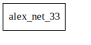

In [120]:
tf.keras.utils.plot_model(alexnet, show_shapes=True, show_dtype=True)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(alexnet, show_shapes=True).create(prog='dot', format='svg'))

In [121]:

alexnet.summary()

Model: "alex_net_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convbatchmaxpool_260 (convb  (None, 27, 27, 48)       17664     
 atchmaxpool)                                                    
                                                                 
 convbatchmaxpool_261 (convb  (None, 27, 27, 48)       17664     
 atchmaxpool)                                                    
                                                                 
 convbatchmaxpool_262 (convb  (None, 3, 3, 128)        154240    
 atchmaxpool)                                                    
                                                                 
 convbatchmaxpool_263 (convb  (None, 3, 3, 128)        154240    
 atchmaxpool)                                                    
                                                                 
 convbatchmaxpool_264 (convb  (None, 1, 1, 192)        